In [166]:
### Import the essential libraries
import pandas as pd
import numpy as np
import os
import glob
import datetime
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import timeit
from timeit import default_timer as timer
from sklearn.svm import SVR
import random
import math
from sklearn.metrics import mean_squared_error
import matplotlib.patches as mpatches
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor  
from sklearn import datasets, linear_model, metrics 
from sklearn.ensemble import RandomForestRegressor

In [22]:
cd C:\Users\desh669\OneDrive - PNNL\Documents\Python Scripts\Mobility Rahul\Anomaly Detection

C:\Users\desh669\OneDrive - PNNL\Documents\Python Scripts\Mobility Rahul\Anomaly Detection


In [23]:
### This Data set contains information about all the sensors which were reported as 'Good' on 25th Sept (Adopted from Caltrans website)
health_data = pd.read_csv('Good_Data_25thSept.csv',sep = ',')
#health_data.head()

## For initial analysis we will only select highway - US101S
health_data_US101S = health_data.loc[health_data['Fwy'] == 'US101-S']

### We do not need information about every lane of that sensor, just keeping the last observation to get the count of 
### number of lanes for that particular loop
health_data_US101S = health_data_US101S.drop_duplicates(subset=['VDS'],keep = 'last')
health_data_US101S = health_data_US101S.reset_index(drop = True)
#print(health_data_US101S.head())
#print(health_data_US101S.shape)

In [98]:
### Now as we know the list of sensors which reported good data on 25th Sept, we will try to get the data reported
### by them from the raw data we are collecting
li_processed_files_day1 = []
def pre_processing(day):
    path = r'C:\Users\desh669\OneDrive - PNNL\Documents\Python Scripts\Mobility Rahul\\' + day + '\\'
    all_files = glob.glob(path + "/*.txt")
    colnames = ["VDS_ID","Lane Count","Loop Count","Loop_1_FLOW","Loop_1_Occupancy","Loop_1_status","Loop_2_FLOW",
                "Loop_2_Occupancy", "Loop_2_status","Loop_3_FLOW","Loop_3_Occupancy","Loop_3_status","Loop_4_FLOW",
                "Loop_4_Occupancy","Loop_4_status","Loop_5_FLOW","Loop_5_Occupancy","Loop_5_status","Loop_6_FLOW",
                "Loop_6_Occupancy","Loop_6_status","Loop_7_FLOW","Loop_7_Occupancy","Loop_7_status","Loop_8_FLOW",
                "Loop_8_Occupancy","Loop_8_status","Loop_9_FLOW","Loop_9_Occuapncy","Loop_9_status","Loop_10_FLOW",
                "Loop_10_Occupancy","Loop_10_status"]
    for filename in all_files:
        if  int(filename[-10:-8]) >= 5 and int(filename[-10:-8]) <=21:        
            df = pd.read_csv(filename,index_col = None, delimiter = ",",names = colnames ,skiprows = 1)
            df= df.drop(['Lane Count','Loop Count','Loop_1_status','Loop_8_status','Loop_2_status','Loop_3_status',
                         'Loop_4_status','Loop_5_status','Loop_6_status','Loop_7_status','Loop_8_status','Loop_9_status',
                         'Loop_10_status'],axis = 1)
            #df = df.loc[df['VDS_ID'].isin(health_data_US101S.VDS.values)] 
            df['time'] = datetime.strptime(str(int(filename[-18:-4])),'%Y%m%d%H%M%S')
            
            li_processed_files_day1.append(df)
        else:
            continue 
    return li_processed_files_day1

### This function is slow because of df = df.loc[df['VDS_ID'].isin(health_data_US101S.VDS.values)] 

start = timer()
pre_processing('20190923')
end = timer()
print(f'Time required to process files for day 1 : {end-start} seconds')

## Saving the list of dataframes in another list as well just for safety
new_list_day1 = []
new_list_day1 = li_processed_files_day1.copy()
#print(len(new_list_day1))

li_processed_files_day1 = [dataframe.reset_index(drop = True) for dataframe in li_processed_files_day1]

print(len(li_processed_files_day1))
print(li_processed_files_day1[0].shape)

li_processed_files_day1 = [df.loc[df['VDS_ID'].isin(health_data_US101S.VDS.values)] for df in li_processed_files_day1]
print(li_processed_files_day1[0].shape)

### getting data in the required format : all indexes are loop IDs and column names are timestamps throughout the day
start = timer()
## Now in order to find the euclidean distances between sensors, first we need to arrange their data in vector format.
temp_df = pd.concat(li_processed_files_day1)


tg = temp_df.groupby('VDS_ID')

## dropping unnecessary columns

li_groups = []
for name, group in tg:
    group = group[[each for each in group.columns if 'Occupancy' not in each]]
    li_groups.append(group)
    
## Rearranging data to get all the sensor Id as index and all the timestamps as column names

li_complete_groups = []
for dataframe in li_groups:
    dataframe = dataframe[[column for column in dataframe.columns if 'Occuapncy' not in column]]
    dataframe = dataframe.dropna(axis = 1,how = 'all')
    dataframe = dataframe.reset_index(drop = True)
    cols = dataframe.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    dataframe = dataframe[cols]
    dataframe = dataframe.T
    new_header = dataframe.iloc[0]
    dataframe = dataframe[1:]
    dataframe.columns = new_header   
    dataframe.index = dataframe.index + '_' + str(dataframe.iloc[0].values[0])
    dataframe = dataframe[1:]
    li_complete_groups.append(dataframe)
#print(len(li_complete_groups))

### since we have few sensors in every list, get them in a dataframe
data_SVR_day1 = pd.concat(li_complete_groups)
#print(data_KNN.shape)



## Let's see how the data looks like
data_SVR_day1.head()

### need to impute the misssing values with zero to be able to calculate the distances 
### (otherwise getting null values in numpy array of distances) - There were not too many missing values since these sensors
### were in good health on 25th Sept. (less than 1% missing values)
data_SVR_day1 = data_SVR_day1.fillna(0)

## check if there are still missing values
#len(data_KNN.index) - data_KNN.count()

## Change the data type to be able to calculate the distances
for col in data_SVR_day1.columns:
    data_SVR_day1[col] = data_SVR_day1[col].astype(float)

data_SVR_day1.head()

Time required to process files for day 1 : 44.88532159102033 seconds
2026
(2047, 22)
(82, 22)


time                2019-09-23 05:00:00  2019-09-23 05:00:30  \
Loop_1_FLOW_716328                  9.0                  4.0   
Loop_2_FLOW_716328                 12.0                 10.0   
Loop_3_FLOW_716328                 11.0                  4.0   
Loop_4_FLOW_716328                 13.0                 12.0   
Loop_1_FLOW_716331                  6.0                  3.0   

time                2019-09-23 05:01:00  2019-09-23 05:01:30  \
Loop_1_FLOW_716328                  5.0                  1.0   
Loop_2_FLOW_716328                  9.0                  8.0   
Loop_3_FLOW_716328                  5.0                  9.0   
Loop_4_FLOW_716328                  7.0                 14.0   
Loop_1_FLOW_716331                  3.0                  7.0   

time                2019-09-23 05:02:00  2019-09-23 05:02:30  \
Loop_1_FLOW_716328                  2.0                  6.0   
Loop_2_FLOW_716328                  7.0                 11.0   
Loop_3_FLOW_716328                  5.0                  9.0   
Loop_4_FLOW_716328                 14.0                 12.0   
Loop_1_FLOW_716331                  6.0                  6.0   

time                2019-09-23 05:03:00  2019-09-23 05:03:30  \
Loop_1_FLOW_716328                  6.0                  3.0   
Loop_2_FLOW_716328                  9.0                  5.0   
Loop_3_FLOW_716328                  7.0                  8.0   
Loop_4_FLOW_716328                 12.0                  9.0   
Loop_1_FLOW_716331                  7.0                 10.0   

time                2019-09-23 05:04:00  2019-09-23 05:04:30  ...  \
Loop_1_FLOW_716328                  6.0                  9.0  ...   
Loop_2_FLOW_716328                  8.0                 11.0  ...   
Loop_3_FLOW_716328                  4.0                  8.0  ...   
Loop_4_FLOW_716328                  8.0                 13.0  ...   
Loop_1_FLOW_716331                  8.0                  3.0  ...   

time                2019-09-23 21:55:00  2019-09-23 21:55:30  \
Loop_1_FLOW_716328                 11.0                 10.0   
Loop_2_FLOW_716328                 10.0                 14.0   
Loop_3_FLOW_716328                 14.0                 17.0   
Loop_4_FLOW_716328                 14.0                 14.0   
Loop_1_FLOW_716331                  9.0                  6.0   

time                2019-09-23 21:56:00  2019-09-23 21:56:30  \
Loop_1_FLOW_716328                  9.0                 13.0   
Loop_2_FLOW_716328                 11.0                 10.0   
Loop_3_FLOW_716328                 12.0                 11.0   
Loop_4_FLOW_716328                 15.0                 12.0   
Loop_1_FLOW_716331                 13.0                 10.0   

time                2019-09-23 21:57:00  2019-09-23 21:57:30  \
Loop_1_FLOW_716328                 12.0                 14.0   
Loop_2_FLOW_716328                 14.0                 14.0   
Loop_3_FLOW_716328                 16.0                 15.0   
Loop_4_FLOW_716328                  9.0                 12.0   
Loop_1_FLOW_716331                 14.0                  8.0   

time                2019-09-23 21:58:00  2019-09-23 21:58:30  \
Loop_1_FLOW_716328                  7.0                 12.0   
Loop_2_FLOW_716328                 17.0                 12.0   
Loop_3_FLOW_716328                  9.0                 13.0   
Loop_4_FLOW_716328                 15.0                 14.0   
Loop_1_FLOW_716331                 12.0                  9.0   

time                2019-09-23 21:59:00  2019-09-23 21:59:30  
Loop_1_FLOW_716328                  9.0                 10.0  
Loop_2_FLOW_716328                 12.0                 10.0  
Loop_3_FLOW_716328                 12.0                 10.0  
Loop_4_FLOW_716328                 20.0                 13.0  
Loop_1_FLOW_716331                 10.0                  5.0  

[5 rows x 2016 columns]

In [99]:
### Now as we know the list of sensors which reported good data on 25th Sept, we will try to get the data reported
### by them from the raw data we are collecting
li_processed_files_day2 = []
def pre_processing(day):
    path = r'C:\Users\desh669\OneDrive - PNNL\Documents\Python Scripts\Mobility Rahul\\' + day + '\\'
    all_files = glob.glob(path + "/*.txt")
    colnames = ["VDS_ID","Lane Count","Loop Count","Loop_1_FLOW","Loop_1_Occupancy","Loop_1_status","Loop_2_FLOW",
                "Loop_2_Occupancy", "Loop_2_status","Loop_3_FLOW","Loop_3_Occupancy","Loop_3_status","Loop_4_FLOW",
                "Loop_4_Occupancy","Loop_4_status","Loop_5_FLOW","Loop_5_Occupancy","Loop_5_status","Loop_6_FLOW",
                "Loop_6_Occupancy","Loop_6_status","Loop_7_FLOW","Loop_7_Occupancy","Loop_7_status","Loop_8_FLOW",
                "Loop_8_Occupancy","Loop_8_status","Loop_9_FLOW","Loop_9_Occuapncy","Loop_9_status","Loop_10_FLOW",
                "Loop_10_Occupancy","Loop_10_status"]
    for filename in all_files:
        if  int(filename[-10:-8]) >= 5 and int(filename[-10:-8]) <=21:        
            df = pd.read_csv(filename,index_col = None, delimiter = ",",names = colnames ,skiprows = 1)
            df= df.drop(['Lane Count','Loop Count','Loop_1_status','Loop_8_status','Loop_2_status','Loop_3_status',
                         'Loop_4_status','Loop_5_status','Loop_6_status','Loop_7_status','Loop_8_status','Loop_9_status',
                         'Loop_10_status'],axis = 1)
            #df = df.loc[df['VDS_ID'].isin(health_data_US101S.VDS.values)] 
            df['time'] = datetime.strptime(str(int(filename[-18:-4])),'%Y%m%d%H%M%S')
            
            li_processed_files_day2.append(df)
        else:
            continue 
    return li_processed_files_day2

### This function is slow because of df = df.loc[df['VDS_ID'].isin(health_data_US101S.VDS.values)] 

start = timer()
pre_processing('20190930')
end = timer()
print(f'Time required to process files for day 1 : {end-start} seconds')

## Saving the list of dataframes in another list as well just for safety
new_list_day2 = []
new_list_day2 = li_processed_files_day2.copy()
#print(len(new_list_day1))

li_processed_files_day2 = [dataframe.reset_index(drop = True) for dataframe in li_processed_files_day2]

print(len(li_processed_files_day2))
print(li_processed_files_day2[0].shape)

li_processed_files_day2 = [df.loc[df['VDS_ID'].isin(health_data_US101S.VDS.values)] for df in li_processed_files_day2]
print(li_processed_files_day2[0].shape)

### getting data in the required format : all indexes are loop IDs and column names are timestamps throughout the day
start = timer()
## Now in order to find the euclidean distances between sensors, first we need to arrange their data in vector format.
temp_df = pd.concat(li_processed_files_day2)


tg = temp_df.groupby('VDS_ID')

## dropping unnecessary columns

li_groups = []
for name, group in tg:
    group = group[[each for each in group.columns if 'Occupancy' not in each]]
    li_groups.append(group)
    
## Rearranging data to get all the sensor Id as index and all the timestamps as column names

li_complete_groups = []
for dataframe in li_groups:
    dataframe = dataframe[[column for column in dataframe.columns if 'Occuapncy' not in column]]
    dataframe = dataframe.dropna(axis = 1,how = 'all')
    dataframe = dataframe.reset_index(drop = True)
    cols = dataframe.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    dataframe = dataframe[cols]
    dataframe = dataframe.T
    new_header = dataframe.iloc[0]
    dataframe = dataframe[1:]
    dataframe.columns = new_header   
    dataframe.index = dataframe.index + '_' + str(dataframe.iloc[0].values[0])
    dataframe = dataframe[1:]
    li_complete_groups.append(dataframe)
#print(len(li_complete_groups))

### since we have few sensors in every list, get them in a dataframe
data_SVR_day2 = pd.concat(li_complete_groups)
#print(data_KNN.shape)



## Let's see how the data looks like
#data_SVR_day2.head()

### need to impute the misssing values with zero to be able to calculate the distances 
### (otherwise getting null values in numpy array of distances) - There were not too many missing values since these sensors
### were in good health on 25th Sept. (less than 1% missing values)
data_SVR_day2 = data_SVR_day2.fillna(0)

## check if there are still missing values
#len(data_KNN.index) - data_KNN.count()

## Change the data type to be able to calculate the distances
for col in data_SVR_day2.columns:
    data_SVR_day2[col] = data_SVR_day2[col].astype(float)

data_SVR_day2.head()

Time required to process files for day 1 : 42.73101873899577 seconds
2040
(2123, 22)
(81, 22)


time                2019-09-30 05:00:00  2019-09-30 05:00:30  \
Loop_1_FLOW_716328                  3.0                 16.0   
Loop_2_FLOW_716328                  9.0                 16.0   
Loop_3_FLOW_716328                  7.0                 11.0   
Loop_4_FLOW_716328                  7.0                  8.0   
Loop_1_FLOW_716331                  9.0                 15.0   

time                2019-09-30 05:01:00  2019-09-30 05:01:30  \
Loop_1_FLOW_716328                  2.0                  5.0   
Loop_2_FLOW_716328                  9.0                 10.0   
Loop_3_FLOW_716328                 15.0                  6.0   
Loop_4_FLOW_716328                 10.0                  8.0   
Loop_1_FLOW_716331                  4.0                  5.0   

time                2019-09-30 05:02:00  2019-09-30 05:02:30  \
Loop_1_FLOW_716328                  5.0                  7.0   
Loop_2_FLOW_716328                 10.0                  6.0   
Loop_3_FLOW_716328                  7.0                 10.0   
Loop_4_FLOW_716328                 10.0                 16.0   
Loop_1_FLOW_716331                  7.0                  8.0   

time                2019-09-30 05:03:00  2019-09-30 05:03:30  \
Loop_1_FLOW_716328                  8.0                  9.0   
Loop_2_FLOW_716328                 10.0                  8.0   
Loop_3_FLOW_716328                  7.0                  3.0   
Loop_4_FLOW_716328                 11.0                 10.0   
Loop_1_FLOW_716331                  7.0                  7.0   

time                2019-09-30 05:04:00  2019-09-30 05:04:30  ...  \
Loop_1_FLOW_716328                  6.0                  7.0  ...   
Loop_2_FLOW_716328                  8.0                  7.0  ...   
Loop_3_FLOW_716328                  9.0                 11.0  ...   
Loop_4_FLOW_716328                 15.0                  9.0  ...   
Loop_1_FLOW_716331                  8.0                 11.0  ...   

time                2019-09-30 21:55:00  2019-09-30 21:55:30  \
Loop_1_FLOW_716328                  4.0                 11.0   
Loop_2_FLOW_716328                 11.0                 15.0   
Loop_3_FLOW_716328                 11.0                 10.0   
Loop_4_FLOW_716328                 16.0                 11.0   
Loop_1_FLOW_716331                  8.0                 13.0   

time                2019-09-30 21:56:00  2019-09-30 21:56:30  \
Loop_1_FLOW_716328                 11.0                  9.0   
Loop_2_FLOW_716328                 17.0                 16.0   
Loop_3_FLOW_716328                 11.0                 12.0   
Loop_4_FLOW_716328                  8.0                 13.0   
Loop_1_FLOW_716331                  8.0                 15.0   

time                2019-09-30 21:57:00  2019-09-30 21:57:30  \
Loop_1_FLOW_716328                 12.0                  9.0   
Loop_2_FLOW_716328                 11.0                 18.0   
Loop_3_FLOW_716328                 14.0                  9.0   
Loop_4_FLOW_716328                 15.0                 17.0   
Loop_1_FLOW_716331                  8.0                  6.0   

time                2019-09-30 21:58:00  2019-09-30 21:58:30  \
Loop_1_FLOW_716328                  6.0                 10.0   
Loop_2_FLOW_716328                 13.0                 14.0   
Loop_3_FLOW_716328                 13.0                 15.0   
Loop_4_FLOW_716328                 11.0                 15.0   
Loop_1_FLOW_716331                  7.0                  6.0   

time                2019-09-30 21:59:00  2019-09-30 21:59:30  
Loop_1_FLOW_716328                  7.0                  7.0  
Loop_2_FLOW_716328                 14.0                 13.0  
Loop_3_FLOW_716328                 14.0                 14.0  
Loop_4_FLOW_716328                 16.0                 13.0  
Loop_1_FLOW_716331                  6.0                  5.0  

[5 rows x 2040 columns]

In [242]:
data_SVR_day1.tail()

time                2019-09-23 05:00:00  2019-09-23 05:00:30  \
Loop_4_FLOW_776328                  2.0                  7.0   
Loop_1_FLOW_776440                  1.0                  3.0   
Loop_2_FLOW_776440                  6.0                  5.0   
Loop_3_FLOW_776440                  4.0                  3.0   
Loop_4_FLOW_776440                  2.0                  2.0   

time                2019-09-23 05:01:00  2019-09-23 05:01:30  \
Loop_4_FLOW_776328                  7.0                  5.0   
Loop_1_FLOW_776440                  7.0                  4.0   
Loop_2_FLOW_776440                  9.0                  9.0   
Loop_3_FLOW_776440                  3.0                  5.0   
Loop_4_FLOW_776440                  2.0                  2.0   

time                2019-09-23 05:02:00  2019-09-23 05:02:30  \
Loop_4_FLOW_776328                  3.0                  4.0   
Loop_1_FLOW_776440                  9.0                  4.0   
Loop_2_FLOW_776440                  3.0                  5.0   
Loop_3_FLOW_776440                  4.0                  5.0   
Loop_4_FLOW_776440                  2.0                  5.0   

time                2019-09-23 05:03:00  2019-09-23 05:03:30  \
Loop_4_FLOW_776328                  4.0                  6.0   
Loop_1_FLOW_776440                  4.0                  9.0   
Loop_2_FLOW_776440                  5.0                  8.0   
Loop_3_FLOW_776440                  2.0                  7.0   
Loop_4_FLOW_776440                  2.0                  1.0   

time                2019-09-23 05:04:00  2019-09-23 05:04:30  ...  \
Loop_4_FLOW_776328                  0.0                  2.0  ...   
Loop_1_FLOW_776440                  6.0                  4.0  ...   
Loop_2_FLOW_776440                  4.0                  5.0  ...   
Loop_3_FLOW_776440                  2.0                  5.0  ...   
Loop_4_FLOW_776440                  3.0                  5.0  ...   

time                2019-09-23 21:55:00  2019-09-23 21:55:30  \
Loop_4_FLOW_776328                  3.0                  6.0   
Loop_1_FLOW_776440                  0.0                  2.0   
Loop_2_FLOW_776440                  5.0                  5.0   
Loop_3_FLOW_776440                  7.0                  5.0   
Loop_4_FLOW_776440                  1.0                  4.0   

time                2019-09-23 21:56:00  2019-09-23 21:56:30  \
Loop_4_FLOW_776328                  4.0                  7.0   
Loop_1_FLOW_776440                  3.0                  3.0   
Loop_2_FLOW_776440                  3.0                  2.0   
Loop_3_FLOW_776440                  1.0                  4.0   
Loop_4_FLOW_776440                  1.0                  5.0   

time                2019-09-23 21:57:00  2019-09-23 21:57:30  \
Loop_4_FLOW_776328                  3.0                  4.0   
Loop_1_FLOW_776440                  1.0                  2.0   
Loop_2_FLOW_776440                  4.0                  5.0   
Loop_3_FLOW_776440                  2.0                  5.0   
Loop_4_FLOW_776440                  3.0                  3.0   

time                2019-09-23 21:58:00  2019-09-23 21:58:30  \
Loop_4_FLOW_776328                  5.0                  5.0   
Loop_1_FLOW_776440                  0.0                  1.0   
Loop_2_FLOW_776440                  2.0                  5.0   
Loop_3_FLOW_776440                  5.0                  5.0   
Loop_4_FLOW_776440                  2.0                  0.0   

time                2019-09-23 21:59:00  2019-09-23 21:59:30  
Loop_4_FLOW_776328                  8.0                  4.0  
Loop_1_FLOW_776440                  2.0                  0.0  
Loop_2_FLOW_776440                  6.0                  2.0  
Loop_3_FLOW_776440                  6.0                  6.0  
Loop_4_FLOW_776440                  4.0                  3.0  

[5 rows x 2016 columns]

In [243]:
data_SVR_day2.tail()

time                2019-09-30 05:00:00  2019-09-30 05:00:30  \
Loop_4_FLOW_776328                  4.0                  5.0   
Loop_1_FLOW_776440                  4.0                  4.0   
Loop_2_FLOW_776440                  4.0                  4.0   
Loop_3_FLOW_776440                  6.0                  5.0   
Loop_4_FLOW_776440                  1.0                  1.0   

time                2019-09-30 05:01:00  2019-09-30 05:01:30  \
Loop_4_FLOW_776328                  6.0                 10.0   
Loop_1_FLOW_776440                  5.0                  8.0   
Loop_2_FLOW_776440                  8.0                  7.0   
Loop_3_FLOW_776440                  1.0                  5.0   
Loop_4_FLOW_776440                  3.0                  3.0   

time                2019-09-30 05:02:00  2019-09-30 05:02:30  \
Loop_4_FLOW_776328                  5.0                  4.0   
Loop_1_FLOW_776440                  2.0                  5.0   
Loop_2_FLOW_776440                  7.0                  2.0   
Loop_3_FLOW_776440                  1.0                  4.0   
Loop_4_FLOW_776440                  1.0                  2.0   

time                2019-09-30 05:03:00  2019-09-30 05:03:30  \
Loop_4_FLOW_776328                  2.0                  8.0   
Loop_1_FLOW_776440                  8.0                 12.0   
Loop_2_FLOW_776440                  5.0                  8.0   
Loop_3_FLOW_776440                  3.0                  7.0   
Loop_4_FLOW_776440                  3.0                  2.0   

time                2019-09-30 05:04:00  2019-09-30 05:04:30  ...  \
Loop_4_FLOW_776328                  3.0                  8.0  ...   
Loop_1_FLOW_776440                  5.0                  7.0  ...   
Loop_2_FLOW_776440                  5.0                 11.0  ...   
Loop_3_FLOW_776440                  6.0                  5.0  ...   
Loop_4_FLOW_776440                  2.0                  2.0  ...   

time                2019-09-30 21:55:00  2019-09-30 21:55:30  \
Loop_4_FLOW_776328                  3.0                  6.0   
Loop_1_FLOW_776440                  3.0                  2.0   
Loop_2_FLOW_776440                  7.0                  3.0   
Loop_3_FLOW_776440                  7.0                  1.0   
Loop_4_FLOW_776440                  5.0                  0.0   

time                2019-09-30 21:56:00  2019-09-30 21:56:30  \
Loop_4_FLOW_776328                  1.0                  5.0   
Loop_1_FLOW_776440                  4.0                  5.0   
Loop_2_FLOW_776440                  6.0                  5.0   
Loop_3_FLOW_776440                  4.0                  4.0   
Loop_4_FLOW_776440                  1.0                  0.0   

time                2019-09-30 21:57:00  2019-09-30 21:57:30  \
Loop_4_FLOW_776328                  7.0                  3.0   
Loop_1_FLOW_776440                 11.0                  8.0   
Loop_2_FLOW_776440                  4.0                  6.0   
Loop_3_FLOW_776440                  2.0                  7.0   
Loop_4_FLOW_776440                  1.0                  2.0   

time                2019-09-30 21:58:00  2019-09-30 21:58:30  \
Loop_4_FLOW_776328                  7.0                  1.0   
Loop_1_FLOW_776440                  6.0                  4.0   
Loop_2_FLOW_776440                  5.0                  7.0   
Loop_3_FLOW_776440                  3.0                  2.0   
Loop_4_FLOW_776440                  1.0                  0.0   

time                2019-09-30 21:59:00  2019-09-30 21:59:30  
Loop_4_FLOW_776328                  5.0                  3.0  
Loop_1_FLOW_776440                  6.0                  7.0  
Loop_2_FLOW_776440                  8.0                  5.0  
Loop_3_FLOW_776440                  1.0                  3.0  
Loop_4_FLOW_776440                  1.0                  2.0  

[5 rows x 2040 columns]

In [290]:
df_Lane4_776440  = pd.DataFrame(data_SVR_day1.T.Loop_4_FLOW_776440)
df_Lane4_776440['N1'] = data_SVR_day1.T.Loop_4_FLOW_764646
df_Lane4_776440['N2'] = data_SVR_day1.T.Loop_4_FLOW_772564
df_Lane4_776440['N3'] = data_SVR_day1.T.Loop_4_FLOW_772193
df_Lane4_776440['N4'] = data_SVR_day1.T.Loop_4_FLOW_716392
df_Lane4_776440['N5'] = data_SVR_day1.T.Loop_2_FLOW_770610
df_Lane4_776440.index = data_SVR_day1.columns
df_Lane4_776440['Month'] = df_Lane4_776440.index.month
df_Lane4_776440['Day'] = df_Lane4_776440.index.day
df_Lane4_776440['Hour'] = df_Lane4_776440.index.hour
df_Lane4_776440['Minute'] = df_Lane4_776440.index.minute
df_Lane4_776440['Second'] = df_Lane4_776440.index.second
print(df_Lane4_776440.head())



df_Lane4_776440_day2 = pd.DataFrame(data_SVR_day2.T.Loop_4_FLOW_776440)
df_Lane4_776440_day2['N1'] = data_SVR_day2.T.Loop_4_FLOW_764646
df_Lane4_776440_day2['N2'] = data_SVR_day2.T.Loop_4_FLOW_772564
df_Lane4_776440_day2['N3'] = data_SVR_day2.T.Loop_4_FLOW_772193
df_Lane4_776440_day2['N4'] = data_SVR_day2.T.Loop_4_FLOW_716392
df_Lane4_776440_day2['N5'] = data_SVR_day2.T.Loop_2_FLOW_770610
df_Lane4_776440_day2.index = data_SVR_day2.columns
df_Lane4_776440_day2['Month'] = df_Lane1_716328_day2.index.month
df_Lane4_776440_day2['Day'] = df_Lane1_716328_day2.index.day
df_Lane4_776440_day2['Hour'] = df_Lane1_716328_day2.index.hour
df_Lane4_776440_day2['Minute'] = df_Lane1_716328_day2.index.minute
df_Lane4_776440_day2['Second'] = df_Lane1_716328_day2.index.second
print(df_Lane4_776440_day2.head())

                     Loop_4_FLOW_776440   N1   N2   N3   N4   N5  Month  Day  \
time                                                                           
2019-09-23 05:00:00                 2.0  2.0  2.0  1.0  2.0  2.0      9   23   
2019-09-23 05:00:30                 2.0  1.0  2.0  3.0  1.0  3.0      9   23   
2019-09-23 05:01:00                 2.0  2.0  1.0  3.0  2.0  2.0      9   23   
2019-09-23 05:01:30                 2.0  1.0  1.0  2.0  1.0  3.0      9   23   
2019-09-23 05:02:00                 2.0  1.0  1.0  1.0  2.0  0.0      9   23   

                     Hour  Minute  Second  
time                                       
2019-09-23 05:00:00     5       0       0  
2019-09-23 05:00:30     5       0      30  
2019-09-23 05:01:00     5       1       0  
2019-09-23 05:01:30     5       1      30  
2019-09-23 05:02:00     5       2       0  
                     Loop_4_FLOW_776440   N1   N2   N3   N4   N5  Month  Day  \
time                                               

In [246]:
X_train = df_Lane4_776440.drop(['Loop_4_FLOW_776440'],axis = 1)
y_train = df_Lane4_776440['Loop_4_FLOW_776440']

X_test = df_Lane4_776440_day2.drop(['Loop_4_FLOW_776440'],axis = 1)
y_test = df_Lane4_776440_day2['Loop_4_FLOW_776440']

In [247]:
start = timer()
regressor=SVR(gamma='scale',kernel='rbf')
regressor.fit(X_train,y_train)
y_pred = regressor.predict(X_test)

end = timer()

print(end-start)

0.6068993040826172


numpy.ndarray

In [248]:
df1 = pd.DataFrame({'Actual_Flow': y_test,'SVR_predicted_flow' : y_pred})
df1.head()

Actual_Flow  SVR_predicted_flow
time                                                
2019-09-30 05:00:00          1.0            3.632500
2019-09-30 05:00:30          1.0            3.730409
2019-09-30 05:01:00          3.0            3.914320
2019-09-30 05:01:30          3.0            4.816456
2019-09-30 05:02:00          1.0            3.481616

In [249]:
np.sqrt(np.mean((df1.SVR_predicted_flow-df1.Actual_Flow)**2))

2.372279123943814

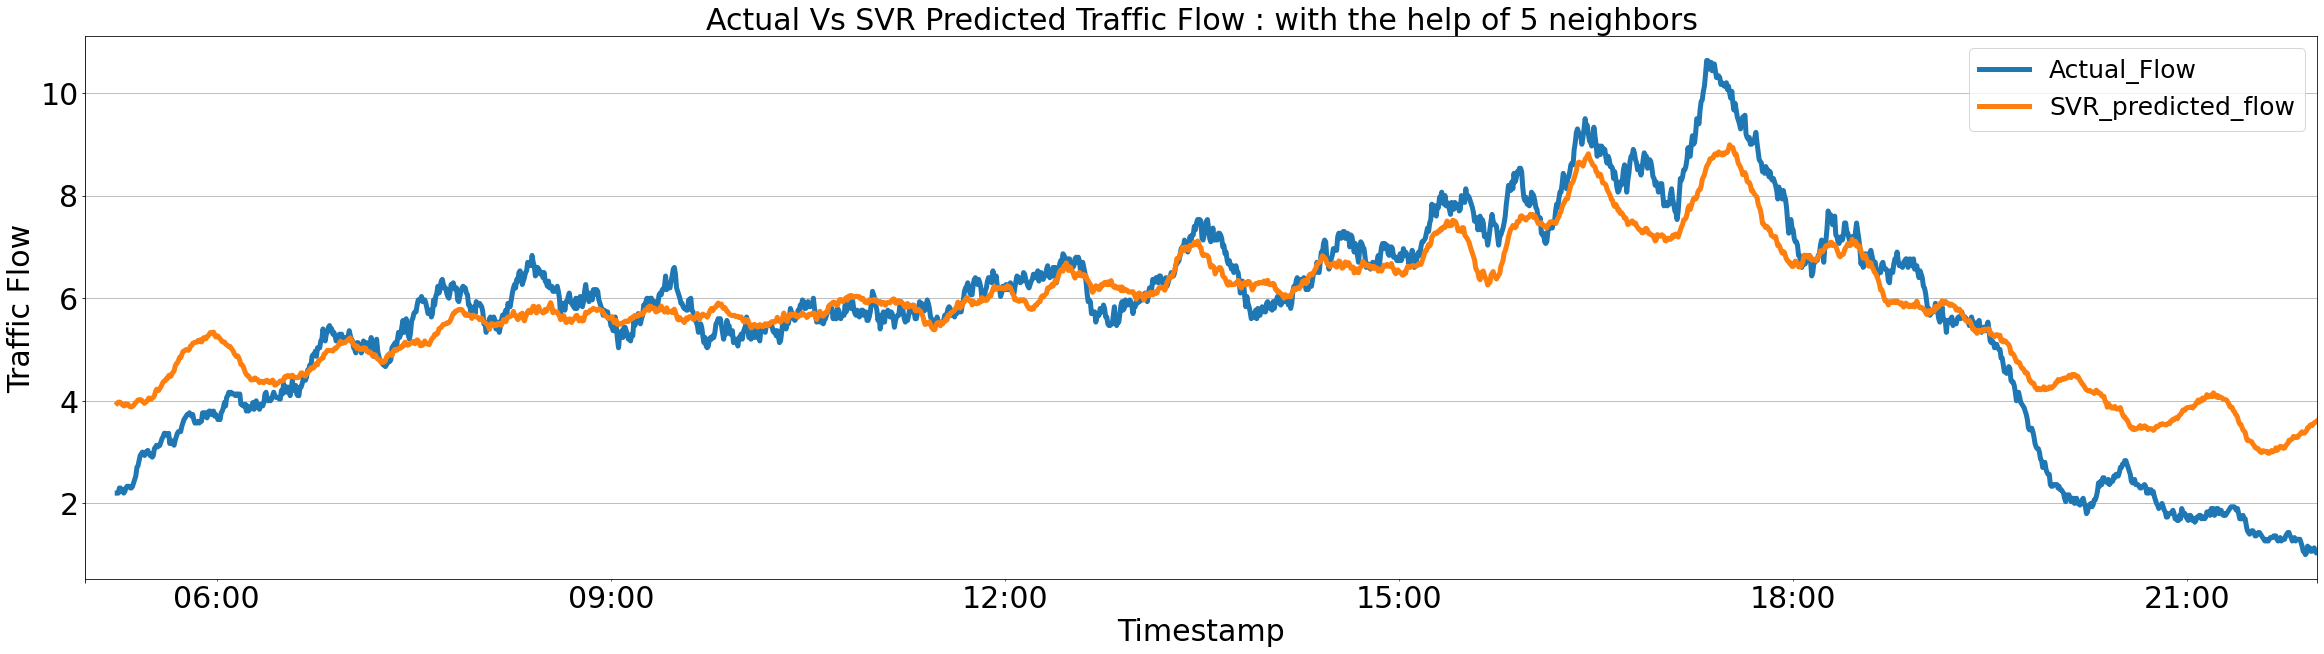

In [250]:
y  = df1.columns
for column in y:
    df1[column].rolling(30).mean().plot(figsize=(40,10),linewidth=5,fontsize=30)
    plt.legend(y,fontsize = 25)
    plt.xlabel('Timestamp',fontsize = 30)
    plt.ylabel('Traffic Flow',fontsize = 30)
    plt.xticks(rotation = 10)
    plt.grid()
    plt.title('Actual Vs SVR Predicted Traffic Flow : with the help of 5 neighbors',fontsize = 30)
    #plt.savefig('SVR_3.png')

In [146]:
df_Lane1_716328  = pd.DataFrame(data_SVR_day1.T.Loop_1_FLOW_716328)
#df_Lane1_716328['N1'] = data_SVR_day1.T.Loop_2_FLOW_716328
#df_Lane1_716328['N2'] = data_SVR_day1.T.Loop_3_FLOW_716328
#df_Lane1_716328['N3'] = data_SVR_day1.T.Loop_1_FLOW_764853
# df_Lane1_716328['N4'] = data_SVR_day1.T.Loop_1_FLOW_716331
df_Lane1_716328['N5'] = data_SVR_day1.T.Loop_2_FLOW_716331
df_Lane1_716328.index = data_SVR_day1.columns
df_Lane1_716328['Month'] = df_Lane1_716328.index.month
df_Lane1_716328['Day'] = df_Lane1_716328.index.day
df_Lane1_716328['Hour'] = df_Lane1_716328.index.hour
df_Lane1_716328['Minute'] = df_Lane1_716328.index.minute
df_Lane1_716328['Second'] = df_Lane1_716328.index.second
print(df_Lane1_716328.head())



df_Lane1_716328_day2 = pd.DataFrame(data_SVR_day2.T.Loop_1_FLOW_716328)
#df_Lane1_716328_day2['N1'] = data_SVR_day2.T.Loop_2_FLOW_716328
#df_Lane1_716328_day2['N2'] = data_SVR_day2.T.Loop_3_FLOW_716328
#df_Lane1_716328_day2['N3'] = data_SVR_day2.T.Loop_1_FLOW_764853
# df_Lane1_716328_day2['N4'] = data_SVR_day2.T.Loop_1_FLOW_716331
df_Lane1_716328_day2['N5'] = data_SVR_day2.T.Loop_2_FLOW_716331
df_Lane1_716328_day2.index = data_SVR_day2.columns
df_Lane1_716328_day2['Month'] = df_Lane1_716328_day2.index.month
df_Lane1_716328_day2['Day'] = df_Lane1_716328_day2.index.day
df_Lane1_716328_day2['Hour'] = df_Lane1_716328_day2.index.hour
df_Lane1_716328_day2['Minute'] = df_Lane1_716328_day2.index.minute
df_Lane1_716328_day2['Second'] = df_Lane1_716328_day2.index.second
print(df_Lane1_716328_day2.head())


X_train = df_Lane1_716328.drop(['Loop_1_FLOW_716328'],axis = 1)
y_train = df_Lane1_716328['Loop_1_FLOW_716328']

X_test = df_Lane1_716328_day2.drop(['Loop_1_FLOW_716328'],axis = 1)
y_test = df_Lane1_716328_day2['Loop_1_FLOW_716328']

                     Loop_1_FLOW_716328   N5  Month  Day  Hour  Minute  Second
time                                                                          
2019-09-23 05:00:00                 9.0  8.0      9   23     5       0       0
2019-09-23 05:00:30                 4.0  5.0      9   23     5       0      30
2019-09-23 05:01:00                 5.0  6.0      9   23     5       1       0
2019-09-23 05:01:30                 1.0  9.0      9   23     5       1      30
2019-09-23 05:02:00                 2.0  4.0      9   23     5       2       0
                     Loop_1_FLOW_716328    N5  Month  Day  Hour  Minute  \
time                                                                      
2019-09-30 05:00:00                 3.0  11.0      9   30     5       0   
2019-09-30 05:00:30                16.0  15.0      9   30     5       0   
2019-09-30 05:01:00                 2.0   9.0      9   30     5       1   
2019-09-30 05:01:30                 5.0   8.0      9   30     5       1 

In [254]:
start = timer()
CART_regressor=DecisionTreeRegressor(random_state = 0) 
CART_regressor.fit(X_train,y_train)
y_pred = CART_regressor.predict(X_test)

end = timer()

print(end-start)

0.04768352396786213


In [257]:
np.sqrt(np.mean((df1.regression_tree_predicted_flow-df1.Actual_Flow)**2))

3.460703770656381

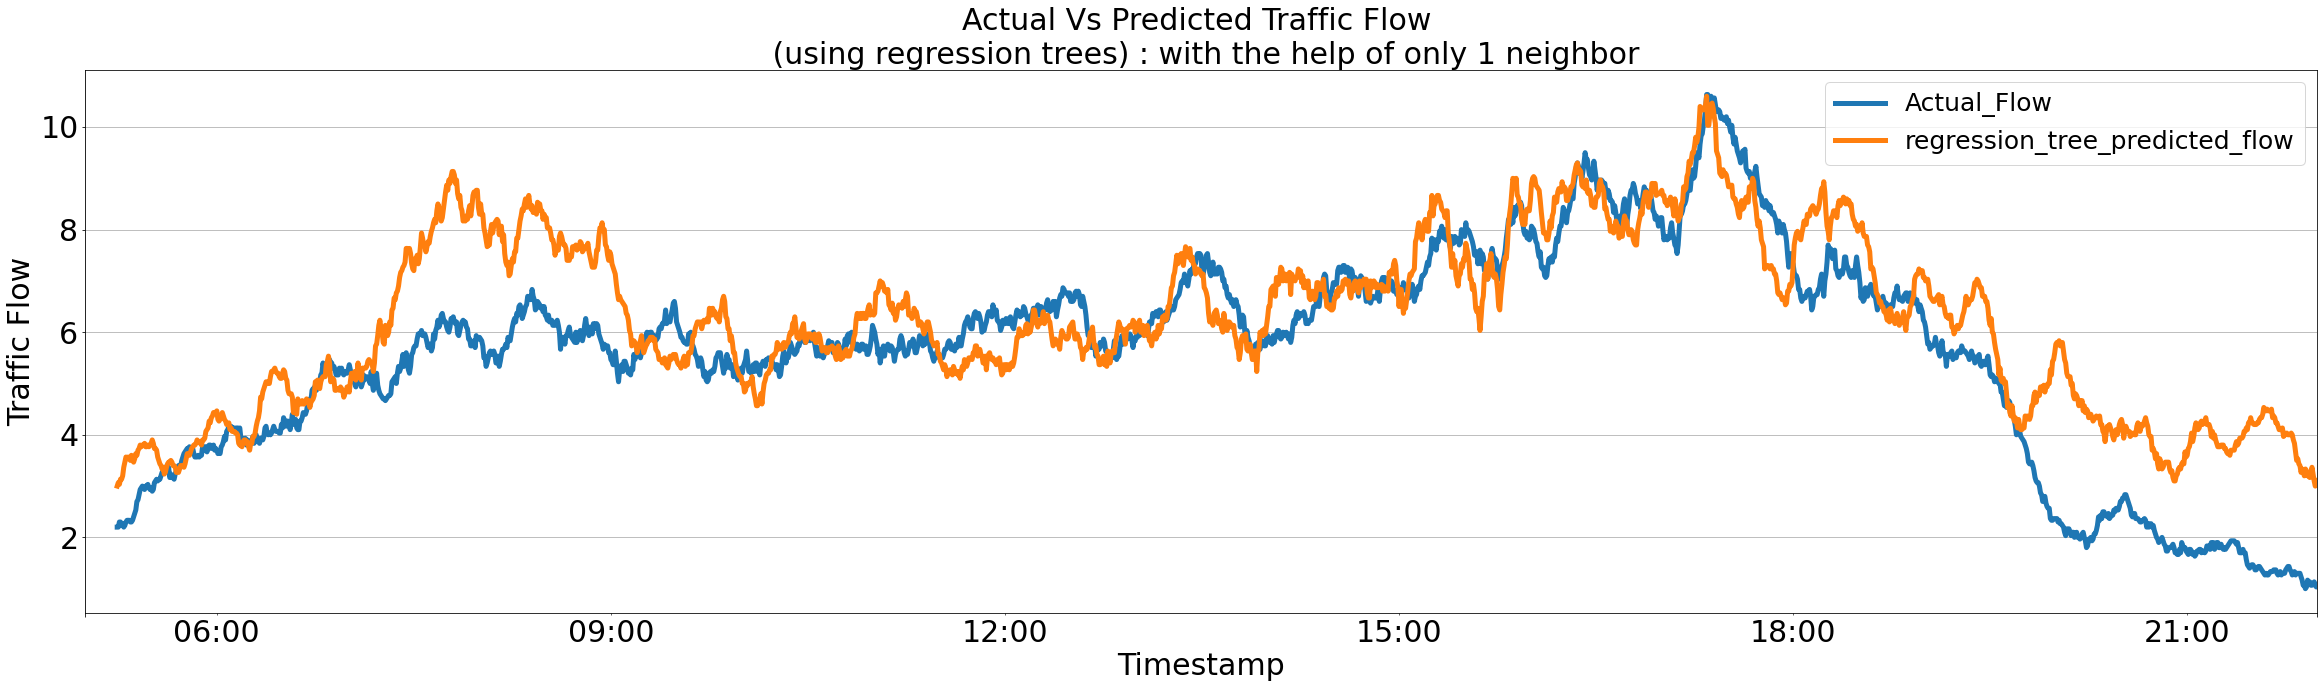

In [256]:
df1 = pd.DataFrame({'Actual_Flow': y_test,'regression_tree_predicted_flow' : y_pred})

y  = df1.columns
for column in y:
    df1[column].rolling(30).mean().plot(figsize=(40,10),linewidth=5,fontsize=30)
    plt.legend(y,fontsize = 25)
    plt.xlabel('Timestamp',fontsize = 30)
    plt.ylabel('Traffic Flow',fontsize = 30)
    plt.xticks(rotation = 10)
    plt.grid()
    plt.title('Actual Vs Predicted Traffic Flow \n (using regression trees) : with the help of only 1 neighbor',fontsize = 30)
    #plt.savefig('regression_tree_1.png')

In [251]:
start = timer()

#create linear regression object 
reg = linear_model.LinearRegression() 
  
# train the model using the training sets 
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)

end = timer()

print(end-start)

0.049826293950900435


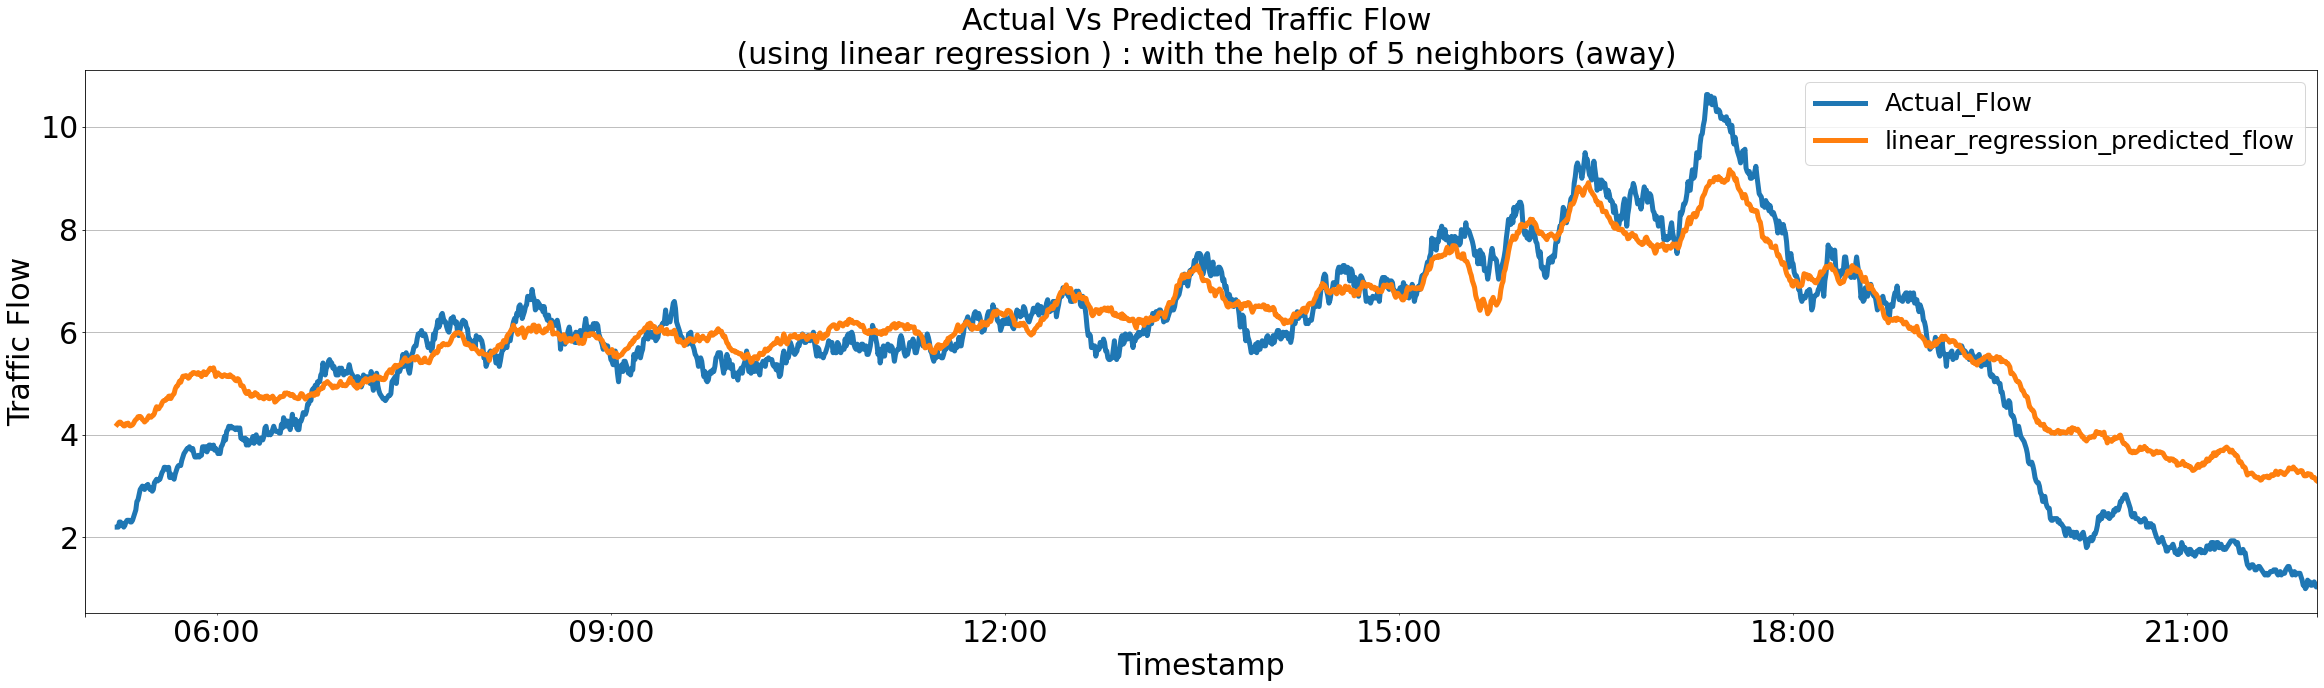

In [252]:
df1 = pd.DataFrame({'Actual_Flow': y_test,'linear_regression_predicted_flow' : y_pred})

y  = df1.columns
for column in y:
    df1[column].rolling(30).mean().plot(figsize=(40,10),linewidth=5,fontsize=30)
    plt.legend(y,fontsize = 25)
    plt.xlabel('Timestamp',fontsize = 30)
    plt.ylabel('Traffic Flow',fontsize = 30)
    plt.xticks(rotation = 10)
    plt.grid()
    plt.title('Actual Vs Predicted Traffic Flow \n (using linear regression ) : with the help of 5 neighbors (away)',fontsize = 30)
    #plt.savefig('linear_regression_3.png')

In [253]:
np.sqrt(np.mean((df1.linear_regression_predicted_flow-df1.Actual_Flow)**2))

2.37206584152685

In [258]:
start = timer()
RF_regressor=RandomForestRegressor(n_estimators = 100,random_state = 0) 
RF_regressor.fit(X_train,y_train)
y_pred = RF_regressor.predict(X_test)

end = timer()

print(end-start)

1.0672761830501258


In [260]:
np.sqrt(np.mean((df1.RF_regression_predicted_flow-df1.Actual_Flow)**2))

2.4478156328753626

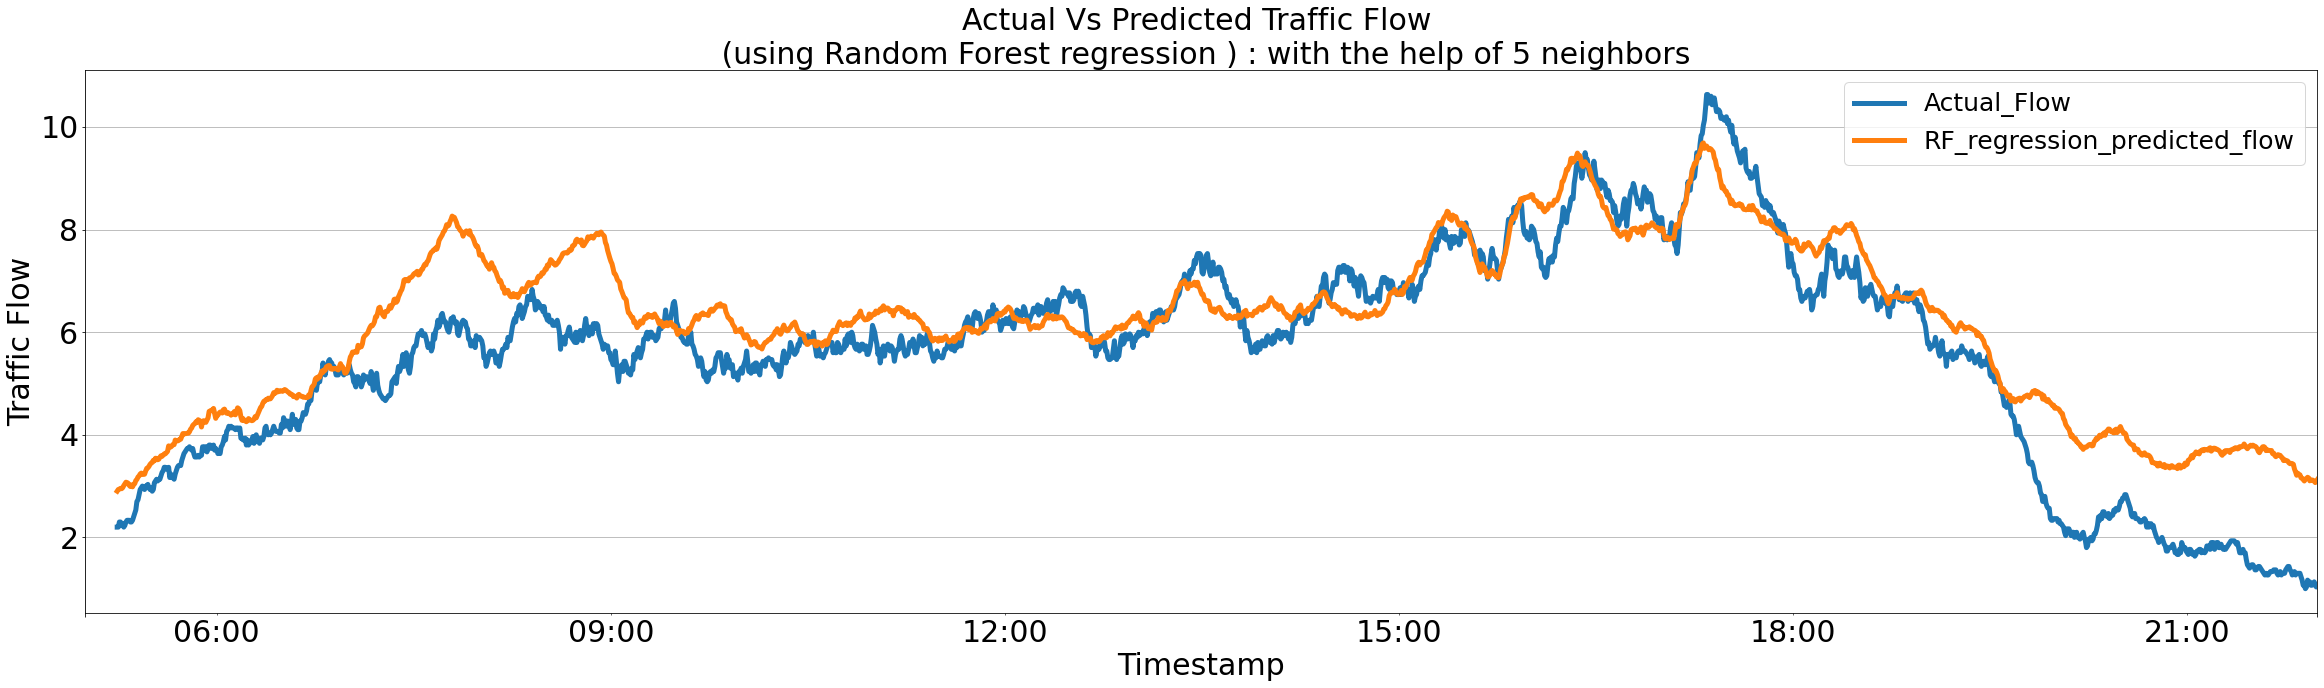

In [259]:
df1 = pd.DataFrame({'Actual_Flow': y_test,'RF_regression_predicted_flow' : y_pred})

y  = df1.columns
for column in y:
    df1[column].rolling(30).mean().plot(figsize=(40,10),linewidth=5,fontsize=30)
    plt.legend(y,fontsize = 25)
    plt.xlabel('Timestamp',fontsize = 30)
    plt.ylabel('Traffic Flow',fontsize = 30)
    plt.xticks(rotation = 10)
    plt.grid()
    plt.title('Actual Vs Predicted Traffic Flow \n (using Random Forest regression ) : with the help of 5 neighbors',fontsize = 30)
    #plt.savefig('RF_regression_3.png')

In [287]:
cd C:\Users\desh669\OneDrive - PNNL\Documents\Rahul Important\Results of analysis

C:\Users\desh669\OneDrive - PNNL\Documents\Rahul Important\Results of analysis


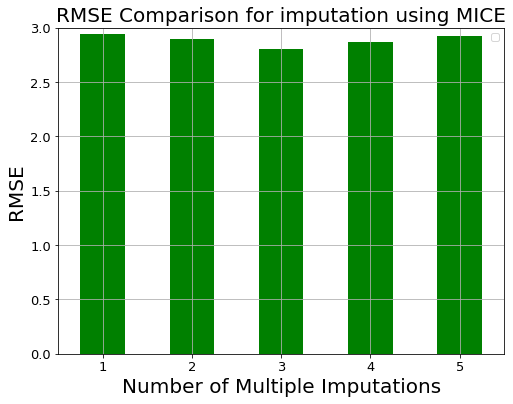

In [289]:
### Creating visualizations for RMSE of different Models used for the imputation

RMSE = [2.94,2.90,2.80,2.87,2.92]
b = pd.DataFrame(RMSE)
names = ['1','2','3','4','5']

b.plot(kind='bar',  color='g', rot=0,figsize = (8,6),fontsize = 13)
plt.xticks([0,1,2,3,4], names,rotation = 0)
plt.ylim(0,3)
plt.xlabel('Number of Multiple Imputations',fontsize = 20)
plt.ylabel("RMSE",fontsize=20)
plt.legend("")
plt.title('RMSE Comparison for imputation using MICE',fontsize = 20)
plt.grid()
plt.savefig('RMSE_MICE.png')
plt.show()


In [263]:
cd C:\Users\desh669\OneDrive - PNNL\Documents\Rahul Important\Results of analysis

C:\Users\desh669\OneDrive - PNNL\Documents\Rahul Important\Results of analysis


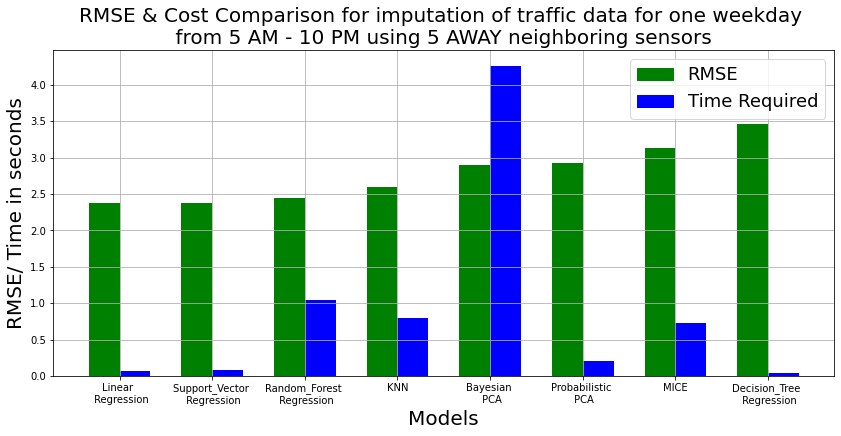

In [264]:
import numpy as np
import matplotlib.pyplot as plt

# The data
#rmse_values = (2.21,2.30,2.32,2.40,2.97,3.01,3.04,3.12)
rmse_values = (2.37,2.37,2.44,2.60,2.90,2.92,3.13,3.46)
#times = (1.04,0.07,0.69,0.80,4.26,0.21,0.05,0.73)
times = (0.07,0.09,1.04,0.80,4.26,0.21,0.73,0.05)
indices = range(len(rmse_values))
# names = ['Random_Forest \n Regression','Linear \n Regression','Support_Vector \n Regression','KNN',
#         'Bayesian \n PCA','Probabilistic \n PCA','Decision_Tree \n Regression','MICE']
names = ['Linear \n Regression','Support_Vector \n Regression','Random_Forest \n Regression','KNN',
        'Bayesian \n PCA','Probabilistic \n PCA','MICE','Decision_Tree \n Regression']
# Calculate optimal width
width = np.min(np.diff(indices))/3.

fig = plt.figure(figsize = (14,6))
ax = fig.add_subplot(111)
ax.bar(indices-width/2.,rmse_values,width,color='g',label='-Ymin')
ax.bar(indices+width/2.,times,width,color='b',label='Ymax')
#tiks = ax.get_xticks().tolist()
plt.xticks([0,1,2,3,4,5,6,7], names,rotation = 0)
#ax.axes.set_xticklabels(names)

plt.xlabel('Models',fontsize = 20)
plt.ylabel("RMSE/ Time in seconds",fontsize=20)
plt.legend("")
plt.title('RMSE & Cost Comparison for imputation of traffic data for one weekday \n from 5 AM - 10 PM using 5 AWAY neighboring sensors ',fontsize = 20)
plt.grid()
green_patch = mpatches.Patch(color='green', label='RMSE')
blue_patch = mpatches.Patch(color='blue', label='Time Required')
plt.legend(handles=[green_patch, blue_patch],fontsize = 18)
plt.savefig('RMSE & Time_all_methods_away_calculation.png')
plt.show()